# Import dataset

In [1]:
import pandas as pd
import json
import numpy as np 
import matplotlib.pyplot as plt
from transformers import set_seed 
import nlpaug.augmenter.word as naw 
# set width for dataframe display
pd.set_option('display.max_colwidth', 200)
# dataset_url = "https://git.io/nlp-with-transformers"
# df_issues = pd.read_json(dataset_url, lines=True)
# print(f"DataFrame shape: {df_issues.shape}")

## Save data to json file

In [2]:
# # save dataset with json format
# df_issues_copy = df_issues.copy() 
# df_issues_copy.to_json("issues.json", orient="records", lines=True)
# # load the data 
df_issues = pd.read_json("issues.json", lines=True)

In [3]:
df_issues.shape

(9930, 26)

In [4]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()


,2
url,https://api.github.com/repos/huggingface/transformers/issues/11044
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting started and issues
user,"{'login': 'stas00', 'id': 10676103, 'node_id': 'MDQ6VXNlcjEwNjc2MTAz', 'avatar_url': 'https://avatars.githubusercontent.com/u/10676103?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1', 'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed', 'name': 'DeepSpeed', 'color': '4D34F7', 'default': False..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated into HF `transformers`. \r\n\r\nWhile I tried to write tests for a ..."


In [5]:
# print all the columns
print(df_issues.columns)

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'body', 'performed_via_github_app',
       'pull_request'],
      dtype='object')


## Process label

In [6]:
df_issues["labels"] = (df_issues["labels"]
 .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [7]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}") 
df_counts.head(10).to_frame().T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage,Core: Pipeline,Feature request
count,2284,649,106,98,64,52,50,46,42,41


In [8]:
label_map = {"Core: Tokenization": "tokenization",
 "New model": "new model",
 "Core: Modeling": "model training",
 "Usage": "usage",
 "Core: Pipeline": "pipeline",
 "TensorFlow": "tensorflow or tf",
 "PyTorch": "pytorch",
 "Examples": "examples",
 "Documentation": "documentation"}

In [9]:
def filter_lables(x): 
    return [label_map[label] for label in x if label in label_map] 
df_issues["labels"] = df_issues["labels"].apply(filter_lables) 
all_labels = list(label_map.values()) 

In [10]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
df_counts.head(10).to_frame().T

Number of labels: 9


labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


## save the unlabels data

In [11]:
df_issues["split"] = "unlabeled"
mark = df_issues["labels"].apply(lambda x: len(x) > 0)
df_issues.loc[mark, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [12]:
# print some examples
for colume in ['title', 'body', 'labels']:
    print(f"{colume}: {df_issues[colume].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [13]:
# concat the title and body 
df_issues['text'] = (df_issues
                     .apply(lambda x: f"{x['title']} +  {x['body']}", axis=1))

In [14]:
df_issues['text'].head()

0    Potential incorrect application of layer norm in BlenderbotSmallDecoder +  In BlenderbotSmallDecoder,  layer norm is applied only on the token embeddings, and not on the hidden_states, whereas in ...
1    Multi-GPU seq2seq example evaluation significantly slower than legacy example evaluation +  \r\n### Who can help\r\n@patil-suraj @sgugger \r\n\r\nModels:\r\nT5\r\n\r\n## Information\r\n\r\nI've be...
2    [DeepSpeed] ZeRO stage 3 integration: getting started and issues +  **[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated...
3    Can't load model to estimater +  I was trying to follow the Sagemaker instructions [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html) to load the model I just trained and te...
4    [LXMERT] Unclear what img_tensorize does with color spaces +  ## Environment info\r\n\r\n- `transformers` version: Not using transformers directly, I'm loading a model "unc-nl

In [15]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset=['text'])
print(f"Remove {(len_before - len(df_issues)) / len_before:.2%} duplicates.")


Remove 1.88% duplicates.


## Plot the dataset

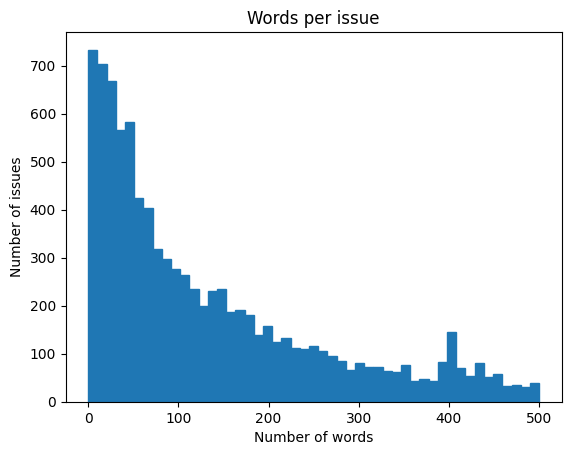

In [16]:
df_issues['text'].str.split().apply(len).hist(bins = np.linspace(0, 500, 50), grid=False, edgecolor='C0') 
plt.title("Words per issue") 
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

# Creating training set

In [17]:
#create balance split by using sk ml
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])  # example of target encoding

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [18]:
np.arange(len(df_issues))

array([   0,    1,    2, ..., 9740, 9741, 9742])

In [19]:
np.expand_dims(np.arange(len(df_issues)), axis=1)

array([[   0],
       [   1],
       [   2],
       ...,
       [9740],
       [9741],
       [9742]])

## split dataset

In [20]:
from skmultilearn.model_selection import iterative_train_test_split 
def balanced_split(df , test_size = 0.5): 
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"]) # transform labels to binary
    ind_train , _ , ind_test, _  = iterative_train_test_split(ind, labels, test_size=test_size) # split data
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]  # return train and test DataFrames

Example of balance split
![Alt text](image-1.png)

In [21]:
from sklearn.model_selection import train_test_split
df_clean = df_issues[["text" , "labels", "split"]].reset_index(drop=True).copy() 
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]].copy()
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]].copy()

np.random.seed(0)
 
df_train , df_tmp = balanced_split(df_sup, test_size=0.5) 
df_valid , df_test = balanced_split(df_tmp, test_size=0.5) 

In [22]:
# df_unsup.head()

## Create datasetDict

In [23]:
from datasets import Dataset, DatasetDict 
ds = DatasetDict({"train": Dataset.from_pandas(df_train.reset_index(drop=True)),
                  "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
                    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
                    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
                  })

## Creating Training slices

In [24]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))) , axis=1) 
print(f"Number of samples: {len(all_indices)}")
indices_pool = all_indices 
lables = mlb.transform(ds["train"]["labels"]) 
train_samples =  [8, 16, 32, 64, 128] 
train_slices , last_k = [], 0 
for i , k in enumerate(train_samples):
    # split off samples necessary to fill the gap to the next split size
    indices_pool, lables, new_slice, _ = iterative_train_test_split(indices_pool, lables, (k - last_k)/len(lables))
    last_k = k 
    if i == 0:
        train_slices.append(new_slice)
    else: train_slices.append(np.concatenate([train_slices[-1], new_slice]))
# add full dataset as last slice 
train_slices.append(all_indices) , train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(x) for x in train_slices]

Number of samples: 223


In [25]:
len(train_slices)


6

In [26]:
indices_pool

array([[  7],
       [ 21],
       [ 24],
       [ 29],
       [ 34],
       [ 39],
       [ 43],
       [ 47],
       [ 49],
       [ 51],
       [ 53],
       [ 59],
       [ 66],
       [ 68],
       [ 71],
       [ 76],
       [ 79],
       [ 81],
       [ 84],
       [ 86],
       [ 87],
       [ 93],
       [ 98],
       [102],
       [103],
       [104],
       [107],
       [108],
       [109],
       [113],
       [114],
       [115],
       [116],
       [117],
       [119],
       [124],
       [125],
       [128],
       [131],
       [134],
       [138],
       [142],
       [144],
       [146],
       [148],
       [150],
       [151],
       [155],
       [156],
       [158],
       [159],
       [160],
       [161],
       [162],
       [164],
       [166],
       [169],
       [171],
       [172],
       [173],
       [177],
       [179],
       [181],
       [182],
       [186],
       [187],
       [188],
       [189],
       [191],
       [192],
       [193],
      

In [27]:
# example data = {
#     "text": ["Text1", "Text2", "Text3", "Text4", "Text5", "Text6", "Text7", "Text8", "Text9", "Text10"],
#     "labels": [["A"], ["B"], ["A", "B"], ["A"], ["A", "B"], ["B"], ["A"], ["A"], ["B"], ["A", "B"]],
# }
# Sample Sizes: [2, 4, 6, 10]
# Train Slices: [array([4, 3], dtype=int64), array([4, 3, 8, 6], dtype=int64), array([4, 3, 8, 6, 1, 7], dtype=int64), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]



In [28]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])


Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


# Implementing a Naive Bayesline

In [29]:
def prepare_labels(batch): 
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch
ds = ds.map(prepare_labels, batched=True) 

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [30]:
# use f1 score and micro and macro to track performance
from collections import defaultdict

In [31]:
train_slices

[array([ 0,  2,  9, 11, 18, 19, 45, 52, 54, 92]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133,   5,  13,  15,
         20,  23,  25,  27,  30,  31,  33,  35,  36,  44,  57,  64,  69,
         73,  74,  78,  80,  90,  91,  99, 105, 123, 136, 141, 152, 180,
        184, 190, 197]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133,   5,  13,  15,
         20,  23,  25,

In [32]:
df_train.head()

,text,labels
26,Add new CANINE model + # 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncod...,[new model]
107,Please implement DUMA: Reading Comprehension with Transposition Thinking + # 🚀 Feature request\r\n\r\n<!-- A clear and concise description of the feature proposal.\r\n Please provide a link t...,[new model]
264,Can DeepSpeed ZeRO-3 be applied for training? + # 🌟 New model addition\r\n\r\nWe have applied DeepSpeed v0.3.10(ZeRO-2) on T5 training. \r\nI heard DeepSpeed ZeRO-3 library has been released 10 ...,[new model]
484,XLSR-53 + # 🚀 Feature request\r\n\r\nIs it possible to use XLSR-53 with transformers in the near future? \r\n,[new model]
566,[examples] should all examples support the predict stage? + This is part of the ongoing effort to sync the example scripts.\r\n\r\nIn https://github.com/huggingface/transformers/issues/10437#issu...,[examples]


In [33]:
macro_scores , micro_scores = defaultdict(list), defaultdict(list)

In [34]:
ds["train"].select([1,2,3])['text']

["Please implement DUMA: Reading Comprehension with Transposition Thinking +  # 🚀 Feature request\r\n\r\n<!-- A clear and concise description of the feature proposal.\r\n     Please provide a link to the paper and code in case they exist. -->\r\nThis one is on the race leaderborad top, will you guys consider implement this?\r\n\r\n## Motivation\r\n\r\n<!-- Please outline the motivation for the proposal. Is your feature request\r\n     related to a problem? e.g., I'm always frustrated when [...]. If this is related\r\n     to another GitHub issue, please link here too. -->\r\n\r\n## Your contribution\r\n\r\n<!-- Is there any way that you could help, e.g. by submitting a PR?\r\n     Make sure to read the CONTRIBUTING.MD readme:\r\n     https://github.com/huggingface/transformers/blob/master/CONTRIBUTING.md -->\r\n",
 "Can DeepSpeed ZeRO-3 be applied for training?  +  # 🌟 New model addition\r\n\r\nWe have applied DeepSpeed v0.3.10(ZeRO-2) on T5 training. \r\nI heard DeepSpeed ZeRO-3 libra

In [35]:
# train the model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report 
from skmultilearn.problem_transform import BinaryRelevance 
from sklearn.feature_extraction.text import CountVectorizer 
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test_labels = np.array(ds["test"]["label_ids"])
    print(f"Train size: {len(ds_train_sample)}")

    # Use a simple count vectorizer to encode our texts as token counts
    count_vectorize = CountVectorizer()
    X_train_counts = count_vectorize.fit_transform(ds_train_sample["text"])
#     print("shape of X_train_counts: ", X_train_counts.shape)
#     print(f"shape of y_train {y_train.shape}")
    X_test_counts = count_vectorize.transform(ds["test"]["text"])
#     print(f"Vocabulary size: {len(count_vectorize.vocabulary_)}")   
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    print("Training done!")
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
            y_test_labels, y_pred_test, target_names=mlb.classes_, zero_division=0,
            output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

Train size: 10
Training done!
Train size: 19
Training done!
Train size: 36
Training done!
Train size: 68
Training done!
Train size: 134
Training done!
Train size: 223
Training done!


In [36]:
macro_scores

defaultdict(list,
            {'Naive Bayes': [0.23288166214995487,
              0.21006897585844955,
              0.24086240556828795,
              0.25730500818220114,
              0.28271105113210376,
              0.27403710305671086]})

In [37]:
micro_scores

defaultdict(list,
            {'Naive Bayes': [0.3604651162790698,
              0.30208333333333337,
              0.41081081081081083,
              0.4435483870967742,
              0.5046728971962616,
              0.5346534653465347]})

In [38]:
len(micro_scores['Naive Bayes'])

6

Naive Bayes


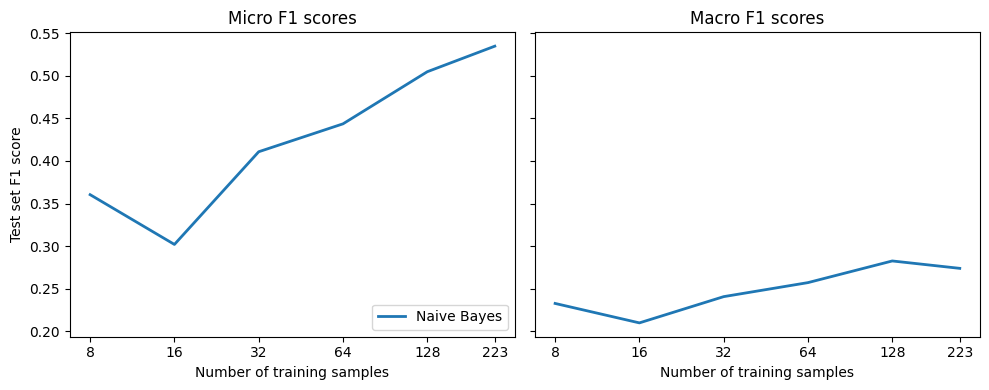

In [39]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for run in micro_scores.keys():
        if run == current_model:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label = run , linewidth=2)            
            ax1.plot(sample_sizes, macro_scores[run], label = run , linewidth=2)
        else:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label=run,linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,linestyle="dashed")
    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

# Working with no labled data

## Import the pipeline

In [40]:
# from transformers import pipeline 
# pipe = pipeline("fill-mask", model="bert-base-uncased")
# movie_desc = "The main characters of the movie madacascar \
# are a lion, a zebra, a giraffe, and a hippo. "
# prompt = "The movie is about [MASK]."
# output = pipe(movie_desc + prompt, targets = ['animals', 'car']) 
# for element in output:
#     print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

In [41]:
# movie_desc = "In the movie transformers aliens \
# can morph into a wide range of vehicles."
# output = pipe(movie_desc + prompt, targets=["animals", "cars"])
# for element in output:
#     print(f"Token {element['token_str']}:\t{element['score']:.3f}%")


## Use Multi-Genre NLI Corpus (MNLI) to zero short the model

In [42]:
ds["train"]

Dataset({
    features: ['text', 'labels', 'label_ids'],
    num_rows: 223
})

In [43]:
import torch
device  = "cuda" if torch.cuda.is_available() else "cpu"

In [44]:
# from transformers import pipeline 
# pipe = pipeline("zero-shot-classification", device=device )
# sample = ds["train"][0]
# output = pipe(sample["text"], all_labels, multi_label=True)
# print(output["sequence"][:400])
# print("\nPredictions:")
# for label, score in zip(output["labels"], output["scores"]):
#      print(f"{label}, {score:.2f}")

In [45]:
# # print pipe arguments
# print(pipe.model.config)

In [46]:
# def zero_shot_pipeline(example): 
#     output = pipe(example["text"], all_labels, multi_label=True)
#     example["predictions"] = output["labels"]   
#     example["scores"] = output["scores"] 
#     return example 
# # ds_zero_shot = ds["valid"].map(zero_shot_pipeline) 


In [47]:
# def get_preds(example, threshold = None , topk = None ): 
#     '''Returns the predicted labels for a given example.'''
#     preds = [] 
#     if threshold: 
#         for label, score in zip(example["predictions"], example["scores"]):
#             if score >= threshold:
#                 preds.append(label)
#     elif topk: 
#         for i in range(topk):
#             preds.append(example["predictions"][i]) 
#     else: 
#         raise ValueError("Either threshold or topk must be set") 
#     return {'pred_label_ids': list(np.squeeze(mlb.transform([preds])))}
# def get_clf_report(ds):
#     y_true = np.array(ds["label_ids"])
#     y_pred = np.array(ds["pred_label_ids"]) 
#     return classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
            

## plot top-k pred

In [48]:
# macros , micros = [] , []
# topks = [1,2,3,4]
# for topk in topks: 
#     ds_zero_shot = ds_zero_shot.map(get_preds, batched = False, fn_kwargs={"topk": topk}) 
#     clf_report = get_clf_report(ds_zero_shot) 
#     macros.append(clf_report["macro avg"]["f1-score"]) 
#     micros.append(clf_report["micro avg"]["f1-score"])

# plt.plot(topks, micros, label="Micro F1 score")
# plt.plot(topks, macros, label="Macro F1 score")
# plt.xlabel("Top k predictions")
# plt.ylabel("F1 score")
# plt.legend(loc = 'best')
# plt.show()

## plot threshold pred

In [49]:
# macros , micros = [] , []
# thresholds = np.linspace(0.01, 1, 100)
# for threshold in thresholds: 
#     # dont print progress bar
#     ds_zero_shot = ds_zero_shot.map(get_preds, batched = False, fn_kwargs={"threshold": threshold}) 
#     clf_report = get_clf_report(ds_zero_shot) 
#     macros.append(clf_report["macro avg"]["f1-score"]) 
#     micros.append(clf_report["micro avg"]["f1-score"])

# plt.plot(thresholds, micros, label="Micro F1 score")
# plt.plot(thresholds, macros, label="Macro F1 score")
# plt.xlabel("Threshold predictions")
# plt.ylabel("F1 score")
# plt.legend(loc = 'best')
# plt.show()

In [50]:
# best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
# print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
# best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
# print(f'Best threshold (micro): {best_t} with F1-score {best_macro:.2f}.')

In [51]:
# micro_scores

In [52]:
# macro_scores

In [53]:
# ds_zero_shot = ds['test'].map(zero_shot_pipeline)
# ds_zero_shot = ds_zero_shot.map(get_preds, batched = False, fn_kwargs={"topk": 1})
# clf_report = get_clf_report(ds_zero_shot)
# for train_slice in train_slices: 
#     macro_scores["Zero-Shot"].append(clf_report["macro avg"]["f1-score"])
#     micro_scores["Zero-Shot"].append(clf_report["micro avg"]["f1-score"])


In [54]:
# plot_metrics(micro_scores, macro_scores, train_samples, "Zero-Shot")


In [55]:
# micro_scores.keys()

# Few shot learning

In [56]:
# set_seed(3)
# aug = naw.ContextualWordEmbsAug(
#     model_path = 'distilbert-base-uncased',
#     device = device, 
#     action = 'substitute' # thay the
# )
# text = 'Transformers are the most popular toys' 
# print(f"Original: {text}") 
# print(f"Augmented Text: {aug.augment(text)}") 

## Augment function

In [57]:
print(device)

cuda


In [58]:
ds_train_sample_copy = ds_train_sample

In [59]:
# def augment_text(batch, transformation_per_example = 10): 
#     """return augment text and label ids

#     Args:
#         batch (_type_): batch of data
#         transformation_per_example (int, optional):  Defaults to 1.

#     Returns:
#         dict: batch of data augmented
#     """
#     text_aug , label_ids = [], [] 
#     for text, labels in zip(batch['text'], batch['label_ids']): 
#         text_aug += [text]
#         label_ids += [labels] 
#         for _ in range(transformation_per_example):
#             text_aug += aug.augment(text)
#             label_ids += [labels]
#     return {'text': text_aug, 'label_ids': label_ids}
# # test function augment text
# batch = {'text': ['Transformers are the most popular toys'], 'label_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}
# output = augment_text(batch, transformation_per_example=3)
# print("output: ", output) 
# print("type of output labels_ids: ", type(output['label_ids']))

## Create training set

In [60]:
# ds_train_sample_copy = ds_train_sample_copy.map(
#     augment_text, 
#     batched = True,
#     remove_columns= ds_train_sample_copy.column_names,
# ).shuffle(seed = 42)

In [61]:
# # iter through ds_train_sample_copy
# dem = 0
# for sample in ds_train_sample_copy:
#     print(sample.keys())
#     print(sample['text'][:100])
#     print(sample['label_ids'][:100])
#     dem += 1
#     if dem == 2:
#         break

## Retrain naive bayes with augment data

In [62]:
# ds_train_sample_copy

In [63]:
# ds_train_sample_copy.select([1,2,3])['text']

In [64]:
# ds_train_sample_copy.select([1,2,3])['label_ids']

In [65]:
# np.random.seed(0)
# all_indices = np.expand_dims(list(range(len(ds_train_sample_copy))) , axis=1) 
# print(f"Number of samples: {len(all_indices)}")
# indices_pool = all_indices 
# lables = np.array(ds_train_sample_copy["label_ids"]) 
# print("shape of lables: ", lables.shape)
# train_samples = [8, 16, 32, 64, 128]
# train_samples = [10* i for i in train_samples]
# train_slices , last_k = [], 0 
# for i , k in enumerate(train_samples):
#     # split off samples necessary to fill the gap to the next split size
#     indices_pool, lables, new_slice, _ = iterative_train_test_split(indices_pool, lables, (k - last_k)/len(lables))
#     last_k = k     
#     if i == 0:
#         train_slices.append(new_slice)
#     else: train_slices.append(np.concatenate([train_slices[-1], new_slice]))
# # add full dataset as last slice 
# train_slices.append(all_indices) , train_samples.append(len(ds_train_sample_copy))
# train_slices = [np.squeeze(x) for x in train_slices]

In [66]:
# # reset Naive Bayes + Aug
# macro_scores["Naive Bayes + Aug"] = []
# micro_scores["Naive Bayes + Aug"] = []
# for train_slice in train_slices:
#     # Get training slice and test data
#     # ds_train_sample_copy = ds["train"].select(train_slice)
#     ds_train_sample_copy_2 = ds_train_sample_copy.select(train_slice)
#     y_train = np.array(ds_train_sample_copy_2["label_ids"])
#     y_test_labels = np.array(ds["test"]["label_ids"])
#     print(f"Train size: {len(ds_train_sample_copy_2)}")

#     # Use a simple count vectorizer to encode our texts as token counts
#     count_vectorize = CountVectorizer()
#     X_train_counts = count_vectorize.fit_transform(ds_train_sample_copy_2["text"])

#     X_test_counts = count_vectorize.transform(ds["test"]["text"])

#     classifier = BinaryRelevance(classifier=MultinomialNB())
#     classifier.fit(X_train_counts, y_train)
#     print("Training done!")
#     # Generate predictions and evaluate
#     y_pred_test = classifier.predict(X_test_counts)
#     clf_report = classification_report(
#             y_test_labels, y_pred_test, target_names=mlb.classes_, zero_division=0,
#             output_dict=True)
#     # Store metrics
#     macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
#     micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

## Plot the metrics

In [67]:
# macro_scores
# defaultdict(list,
#             {'Naive Bayes': [0.23288166214995487,
#               0.21006897585844955,
#               0.24086240556828795,
#               0.25730500818220114,
#               0.28271105113210376,
#               0.27403710305671086],
#              'Zero-Shot': [0.3869340923536515,
#               0.3869340923536515,
#               0.3869340923536515,
#               0.3869340923536515,
#               0.3869340923536515,
#               0.3869340923536515],
#              'Naive Bayes + Aug': [0.27235449735449735,
#               0.278589655958077,
#               0.33758862806420187,
#               0.4415159953502743,
#               0.4563280715286368,
#               0.4832651770367019]})

In [68]:
# train_samples = [8, 16, 32, 64, 128, 223]
# plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

# Embeddings_as_a_lookup_table.ipynb

In [69]:
import torch 
from transformers import AutoTokenizer, AutoModel 
model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)
def mean_pooling(model_output, anttention_mask): 
    # Extract the token embedding 
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings 
    # compute attention mask 
    input_mask_expanded = (anttention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float()) 
    # Sum the embeddings , but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) 
    sum_mark = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mark

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True, 
                       max_length=128, return_tensors="pt",).to(device)
    with torch.no_grad(): 
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [70]:
tokenizer.eos_token

'<|endoftext|>'

In [71]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=128)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=128)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=128)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

## Use FAISS library to embedding

In [72]:
embs_train.add_faiss_index("embedding") # add faiss index

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

## Use FAISS library to search

In [75]:
i , k = 2 , 3 # Select the first query and 3 nearest neighbors
rn , nl = "\r\n\r\n" , "\n" # Used to remove newlines in text for compact display  

query = np.array(embs_valid[i]["embedding"], dtype = np.float32) # query to search is embedding  
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)  # search from train data 

print(f"QUERY LABELS: {embs_valid[i]['labels']}") # print query labels (input)
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n") # print query text (input)
print("="*50)
print(f"Retrieved documents:") # print retrieved documents
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")
# all the text same label

QUERY LABELS: ['examples']
QUERY TEXT:
[example scripts] inconsistency around eval vs val +  * `val` == validation set (split)
* `eval` == evaluation (mode)
those two are orthogonal to each other - one is a split, another is a model's  [...]

Retrieved documents:
TEXT:
[readability] consolidate examples/summarization/bart  and examples/summarization/t5 +  This involves 
- [ ]  consolidating README.md 
- [ ]  consolidating evaluate_cnn.py scripts.
- [ ]  evaluat [...]
SCORE: 93.93
LABELS: ['examples']
TEXT:
TF: Faster to way to set one column/all but one column of a tensor to -inf +  in `_force_token_id_to_be_generated` we have much simpler torch code:
```python
scores[:, [x for if x != token_id]] = -f [...]
SCORE: 95.44
LABELS: ['tensorflow or tf']
TEXT:
[examples] should all examples support the predict stage? +  This is part of the ongoing effort to sync the example scripts.
In https://github.com/huggingface/transformers/issues/10437#issuecomment [...]
SCORE: 98.52
LABELS: ['examples

## Find the best value for k

In [81]:
def get_sample_pred(sample, m): 
    return (np.sum(sample["label_ids"], axis = 0) >= m ).astype(int) 
def find_best_k_m(ds_train, valid_queries, valid_labels, max_k = 17): 
    max_k = min(max_k, len(ds_train)) 
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k): 
        for m in range(1 , k + 1 ):
            _ , samples = ds_train.get_nearest_examples_batch("embedding", valid_queries, k=k)
            preds = np.array([get_sample_pred(sample, m) for sample in samples])
            clf_report = classification_report(valid_labels, preds,
                                               target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro 

/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


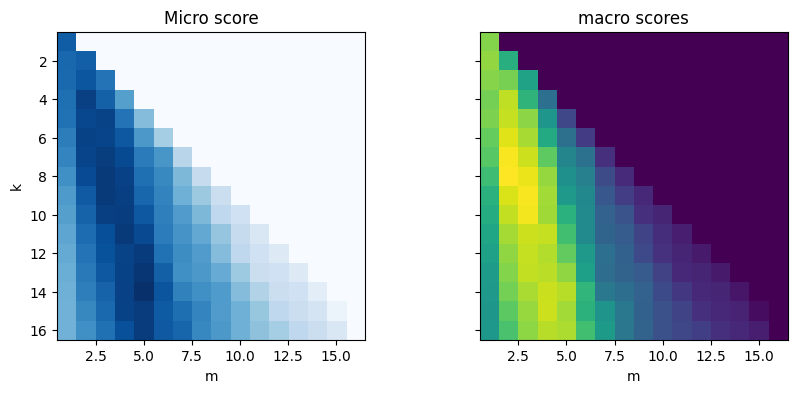

In [82]:
valid_labbels = np.array(embs_valid["label_ids"]) 
valid_queries = np.array(embs_valid["embedding"], dtype = np.float32) 
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labbels)

fig , (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True) 
ax0.imshow(perf_micro, cmap="Blues")
ax1.imshow(perf_macro, cmap="Blues")

ax0.set_title(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("Micro score")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0,ax1]:
    ax.set_xlim(0.5,17-0.5)
    ax.set_ylim(17-0.5,0.5)
    ax.set_xlabel("m")
plt.show()

In [83]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")


Best k: 14, best m: 5
